# EasyVVUQ execution on HPC machines with QCG-PilotJob

**Author**: Bartosz Bosak, PSNC (bbosak@man.poznan.pl)

This tutorial is an extension of the EasyVVUQ basic tutorial available [here](https://mybinder.org/v2/gh/UCL-CCS/EasyVVUQ/a6852d6c5ba36f15579e601d7a8d074505f31084?filepath=tutorials%2Fbasic_tutorial.ipynb) to present how QCG-PilotJob tool can be used for HPC execution of the EasyVVUQ workflow. 

We assume that you are already familiar with the idea of the basic tutorial, thus here we don't go into the conceptual detials of the presented scenario and concentrate on the usage of QCG-PilotJob system only. However, let us provide a very brief introduction as it can be helpful. 

In this example we present the same sensitivity analysis scenario of a model of vertical deflection of a tube as was used in the basic tutorial.  This is a relatively simple application that takes json file with several parameters as an input and genenerates a json file as an output. The sets of input paramaeters are generated accordingly with the selected distributions and then for each set, the model needs to be run, and finally the results of such executions need to be analysed. 

Since for many scenarios there are a lot of calculations required, in terms of both the number of model executions and the computational requirements of a single execution, usage of large scale resources may be necessary. To this end and to enable efficient and flexible execution of demanding parts of EasyVVUQ workflow on HPC machines, EasyVVUQ has been integrated with the QCG-PilotJob tool. 

# Campaign

We need to import a few libraries that are required for our example. 

In [1]:
import easyvvuq as uq
import chaospy as cp
import matplotlib.pyplot as plt

We will describe the parameters. This is done for validation purposes (so that input parameters outside valid ranges given an error. Also this is where you can specify default values for input parameters that you don't want to vary in the analysis. Only the type and the default value fields are mandatory.

In [2]:
params = {
    "F": {"type": "float", "default": 1.0}, 
    "L": {"type": "float", "default": 1.5}, 
    "a": {"type": "float", "min": 0.7, "max": 1.2, "default": 1.0}, 
    "D": {"type": "float", "min": 0.75, "max": 0.85, "default": 0.8},
    "d": {"type": "float", "default": 0.1},
    "E": {"type": "float", "default": 200000},
    "outfile": {"type": "string", "default": "output.json"}
}

Next step is to specify how the input files for the simulation are to be created and how EasyVVUQ is to parse the output of the simulation. This is the job of the Encoder and Decoder classes. Our simulation takes a very simple JSON file as input. So we can just use the GenericEncoder which is a template based encoder. It will replace all keys in the template file with respective values. In this case they are identified by the ```$``` that precedes them. Alternatively, there are more complex encoders based on, for example, the [Jinja2](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.encoders.html#module-easyvvuq.encoders.jinja_encoder) templating language. Encoders can also do more complicated things, such as prepare a [directory structure](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.encoders.html#module-easyvvuq.encoders.directory_builder) if your simulation requires such. If it requires several input files you can use a [multiencoder](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.encoders.html#module-easyvvuq.encoders.multiencoder) to combine several encoders, each of which responsible for a single input file. They can also be used to [copy](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.encoders.html#module-easyvvuq.encoders.copy_encoder) files over to the run directory.

Decoder is responsible for parsing the otuput of the simulation. We use the [JSONDecoder](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.decoders.html#module-easyvvuq.decoders.json) to extract the needed value. There also exist ready made decoders for [YAML](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.decoders.html#module-easyvvuq.decoders.yaml) and [CSV](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.decoders.html#module-easyvvuq.decoders.simple_csv). You can also easily write your own by inheriting from the BaseDecoder class.

In [3]:
encoder = uq.encoders.GenericEncoder(template_fname='beam.template', delimiter='$', target_filename='input.json')
decoder = uq.decoders.JSONDecoder(target_filename='output.json', output_columns=['g1'])

Campaign is the central hub in which operations take place. It is responsible for running your simulations, gathering the results, storing them in the Database, retrieving them for analysis, etc. The Campaign in EasyVVUQ is very powerful and supports multiple applications, sampling, analysis and execution methods. It also lets you save progress and retrieve results later for analysis. Here we only look at a simple case.

In [4]:
campaign = uq.CampaignQCGPJ(name='beam', params=params, encoder=encoder, decoder=decoder)

First we need to define the input parameter distributions. We have chosen 4 of the 6 available inputs. This is partly because this means that we won't have to sample at too many points and partly because I've found that these influence the output variable the most.

In [5]:
vary = {
    "F": cp.Normal(1, 0.1),
    "L": cp.Normal(1.5, 0.01),
    "a": cp.Uniform(0.7, 1.2),
    "D": cp.Triangle(0.75, 0.8, 0.85)
}

We have to choose the sampler next. For this task we can use either [Stochastic Collocation](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.sampling.html#module-easyvvuq.sampling.stochastic_collocation), [Polynomial Chaos Expansion](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.sampling.html#module-easyvvuq.sampling.pce) or [QMC](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.sampling.html#module-easyvvuq.sampling.qmc) samplers. Stochastic Collocation is fast for this problem size so that is what we chose.

In [25]:
campaign.set_sampler(uq.sampling.SCSampler(vary=vary, polynomial_order=3))
campaign.draw_samples()
campaign.populate_runs_dir()

['Run_1',
 'Run_2',
 'Run_3',
 'Run_4',
 'Run_5',
 'Run_6',
 'Run_7',
 'Run_8',
 'Run_9',
 'Run_10',
 'Run_11',
 'Run_12',
 'Run_13',
 'Run_14',
 'Run_15',
 'Run_16',
 'Run_17',
 'Run_18',
 'Run_19',
 'Run_20',
 'Run_21',
 'Run_22',
 'Run_23',
 'Run_24',
 'Run_25',
 'Run_26',
 'Run_27',
 'Run_28',
 'Run_29',
 'Run_30',
 'Run_31',
 'Run_32',
 'Run_33',
 'Run_34',
 'Run_35',
 'Run_36',
 'Run_37',
 'Run_38',
 'Run_39',
 'Run_40',
 'Run_41',
 'Run_42',
 'Run_43',
 'Run_44',
 'Run_45',
 'Run_46',
 'Run_47',
 'Run_48',
 'Run_49',
 'Run_50',
 'Run_51',
 'Run_52',
 'Run_53',
 'Run_54',
 'Run_55',
 'Run_56',
 'Run_57',
 'Run_58',
 'Run_59',
 'Run_60',
 'Run_61',
 'Run_62',
 'Run_63',
 'Run_64',
 'Run_65',
 'Run_66',
 'Run_67',
 'Run_68',
 'Run_69',
 'Run_70',
 'Run_71',
 'Run_72',
 'Run_73',
 'Run_74',
 'Run_75',
 'Run_76',
 'Run_77',
 'Run_78',
 'Run_79',
 'Run_80',
 'Run_81',
 'Run_82',
 'Run_83',
 'Run_84',
 'Run_85',
 'Run_86',
 'Run_87',
 'Run_88',
 'Run_89',
 'Run_90',
 'Run_91',
 'Run_92

For this tutorial we have chosen to run the simulation on the local machine. This will done in parallel with up to 8 tasks running concurrently. Alternatives are execution in the Cloud (via the [ExecuteKubernetes](https://easyvvuq.readthedocs.io/en/dev/easyvvuq.actions.html#module-easyvvuq.actions.execute_kubernetes) action) or on HPC machines.

In [26]:
import os 
import multiprocessing as mp

mp.set_start_method("spawn", force=True)
mp.freeze_support()

cmd = f"{os.getcwd()}/beam input.json"

qcgpj_manager = uq.pools.qcgpj.QCGPJ().create_manager()
qcgpj_action = uq.actions.ExecuteQCGPJ(qcgpj_manager, cmd, task_requirements=uq.pools.qcgpj.TaskRequirements(cores=1))

campaign.apply_for_each_run_dir(
    qcgpj_action,
    qcgpj_manager
)

qcgpj_manager.finish()


The execution can take a bit since we need to generate several hundred samples. We asked it to evaluate 8 samples in parallel. You can track progress by using the ```progress``` method. You can also check progress automatically and resume execution after it is done if you want to run this inside a script rather than interactively.

We then call the analyse method whose functionality will depend on the sampling method used. It returns an [AnalysisResults]() object which can be used to retrieve numerical values or plot the results. In this case Sobols indices.

In [28]:
results = campaign.analyse(qoi_cols=['g1'])


We can plot the results in a treemap format. Each square representing the relative influence of that parameter to the variance of the output variable (vertical displacement at point ```a```). A square labeled ```higher orders``` represent the influence of the interactions between the input parameters.

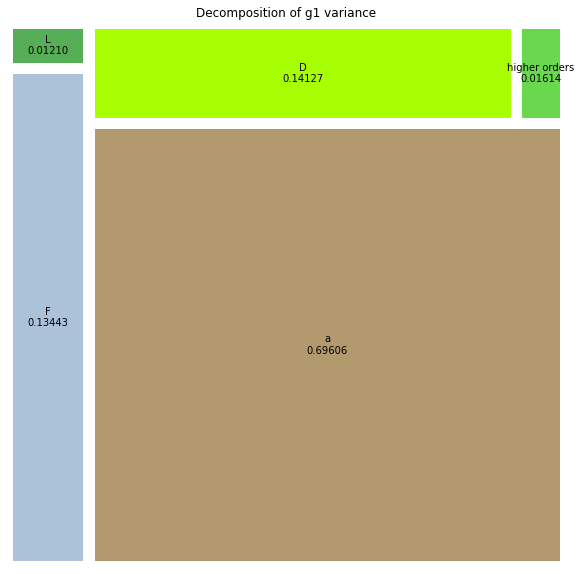

In [29]:
results.plot_sobols_treemap('g1', figsize=(10, 10))
plt.axis('off');

Alternatively you can get the Sobol index values using the method call below.

In [ ]:
results.sobols_first()